## Import

In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import json

## 야후 파이낸스 패키지
import yfinance as yf

## 함수 모음
import graphModule as gm
import myfuncs as mf
    
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoading

In [2]:
## 보간용 필수 데이터
## SCHD 보간용 (DJDIV100)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)

## 기본지수 데이터
tickers = ['^IXIC', '^GSPC', '^DJI', 'GC=F']
## 데이터 다운로드
df_ref = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ref = df_ref['Close']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']

## Imputation
df_ref = mf.imputation(df_ref, '^GSPC', '^DJI')
df_ref = mf.imputation(df_ref, '^DJI', 'Div')

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div']]
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div']
df_ref[_cols] = df_ref[_cols]/df_ref[_cols].iloc[0]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div']

[*********************100%%**********************]  4 of 4 completed


0.9187882736115898
0.8698779253276526


In [3]:
tickers = ["QQQ", "SCHD"]
## 데이터 다운로드
df_ori = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ori = df_ori['Close']

[*********************100%%**********************]  2 of 2 completed


In [4]:
## 보간 시계열 데이터: SCHD 데이터 신뢰도 주의(1975 ~ 1998)
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = mf.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = mf.imputation(df_imp, 'Div', 'SCHD')
df_imp = df_imp*100
## 신뢰도 높은 보간 시계열 데이터
df_conf = df_imp[div.dropna().index[0]:]
df_conf = df_conf/df_conf.iloc[0]*100
## 비보간 시계열 데이터
df_cut = df_imp[df_ori.dropna().index[0]:]
df_cut = df_cut/df_cut.iloc[0]*100

1.0448316661313364
0.9968914306152722


In [5]:
# ## 데이터 내려받기 ## 주석을 풀고 활용하세요
# df_conf.to_excel('df_conf.xlsx')

## Analysis

In [6]:
## 시각화 대상 선택
assets = ['SCHD', 'QQQ']
plot_df = df_conf.copy()

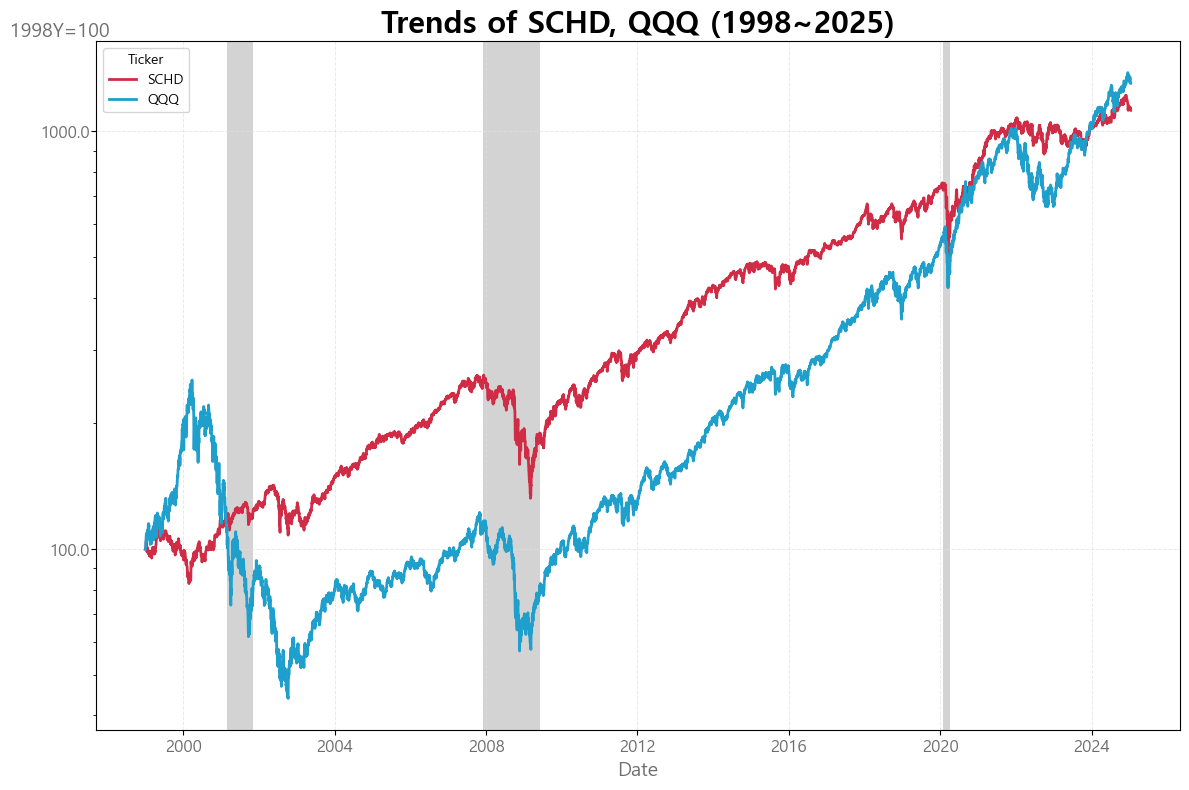

In [7]:
## 누적 수익률
gm.trend_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

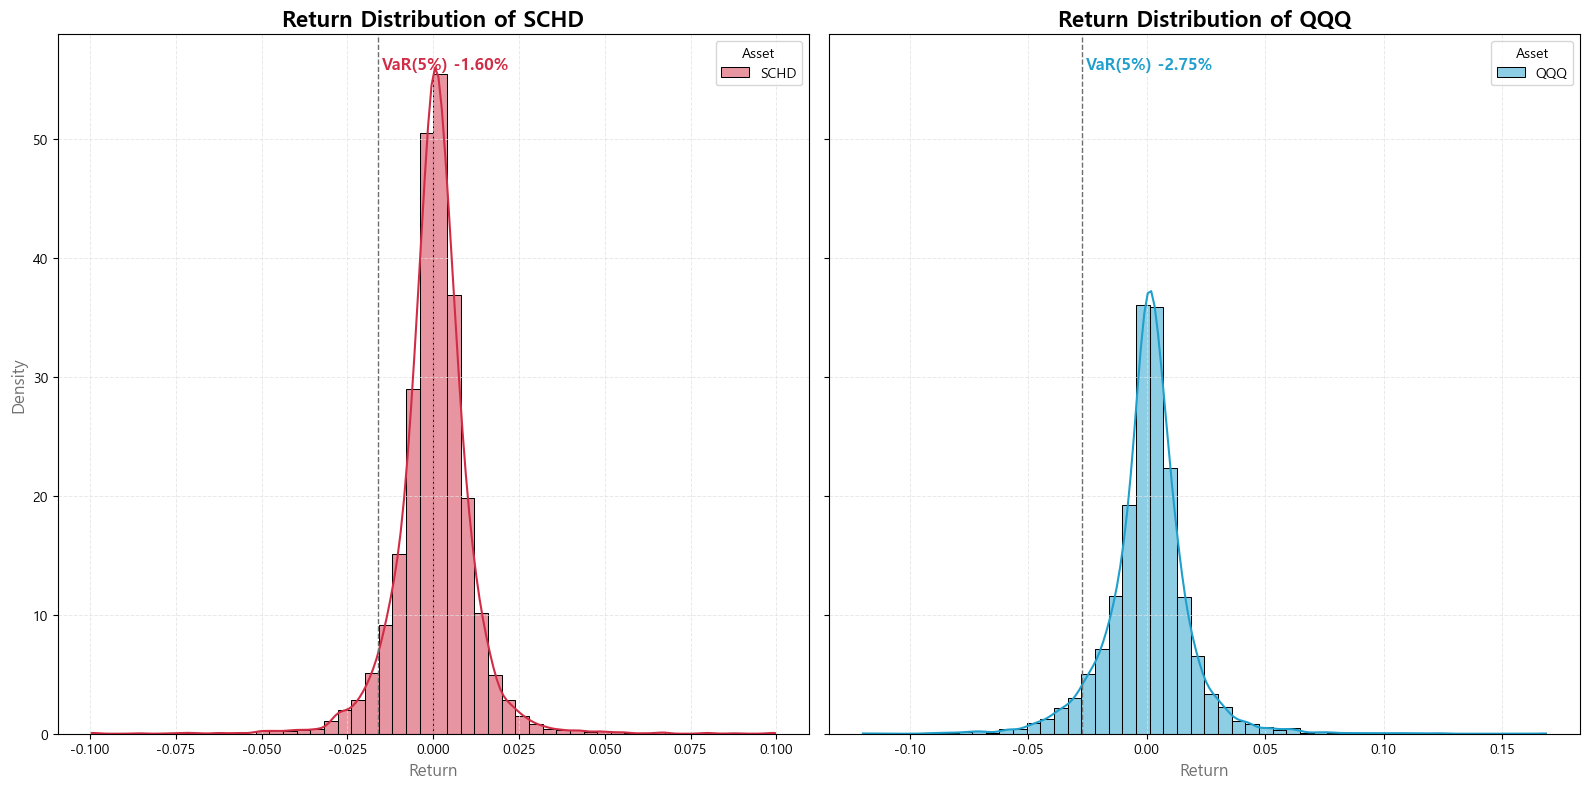

In [8]:
## 수익률 히스토그램 with VaR(5%)
gm.asset_histogram_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

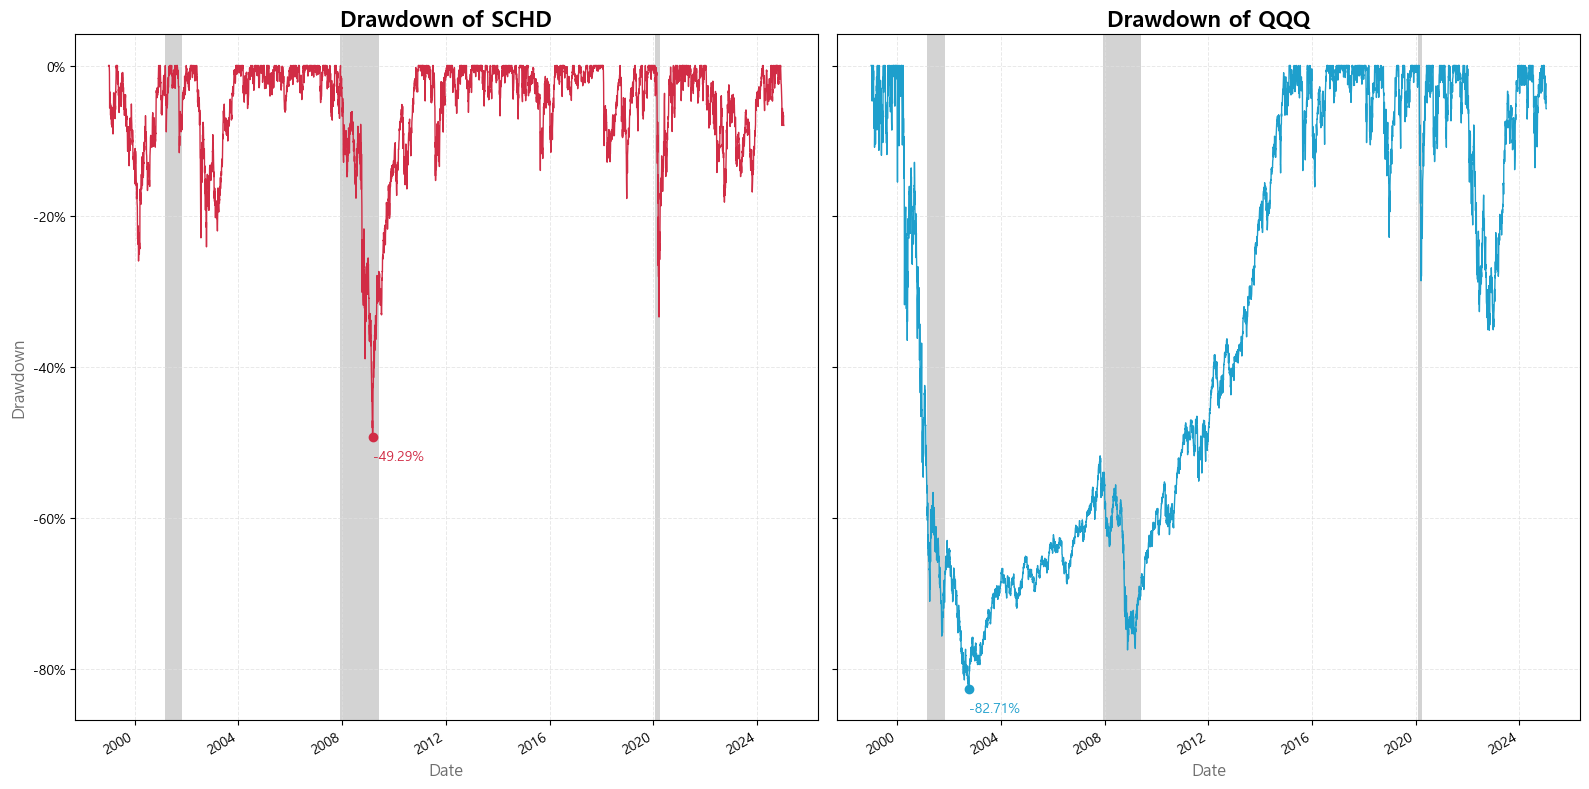

In [9]:
## Drawdown
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

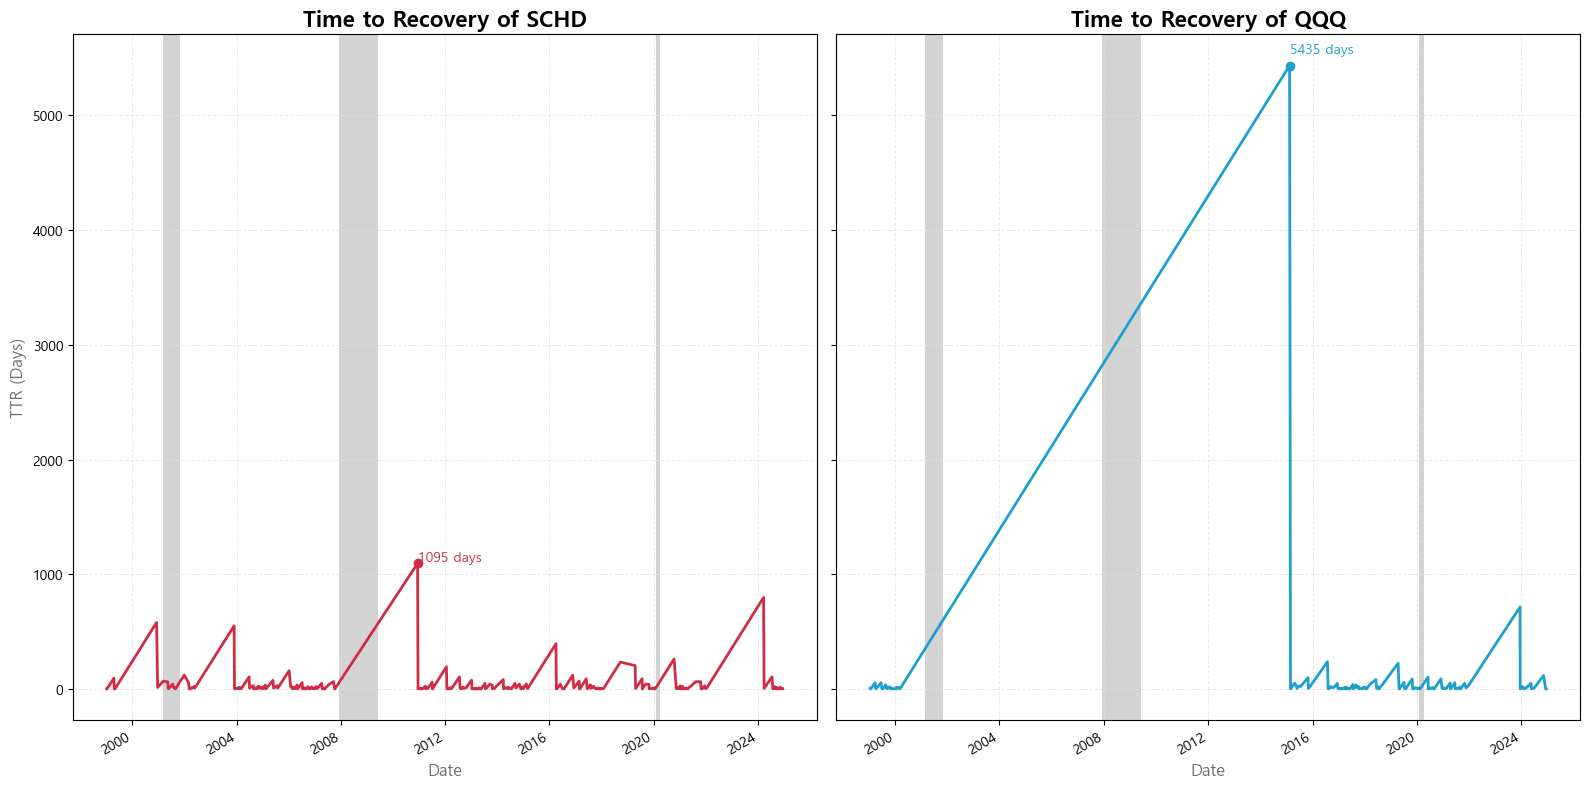

In [10]:
## 전고점 회복 기간(TTR)
ttr_df = mf.get_ttr_df(df_conf, assets)
gm.ttr_plot(ttr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

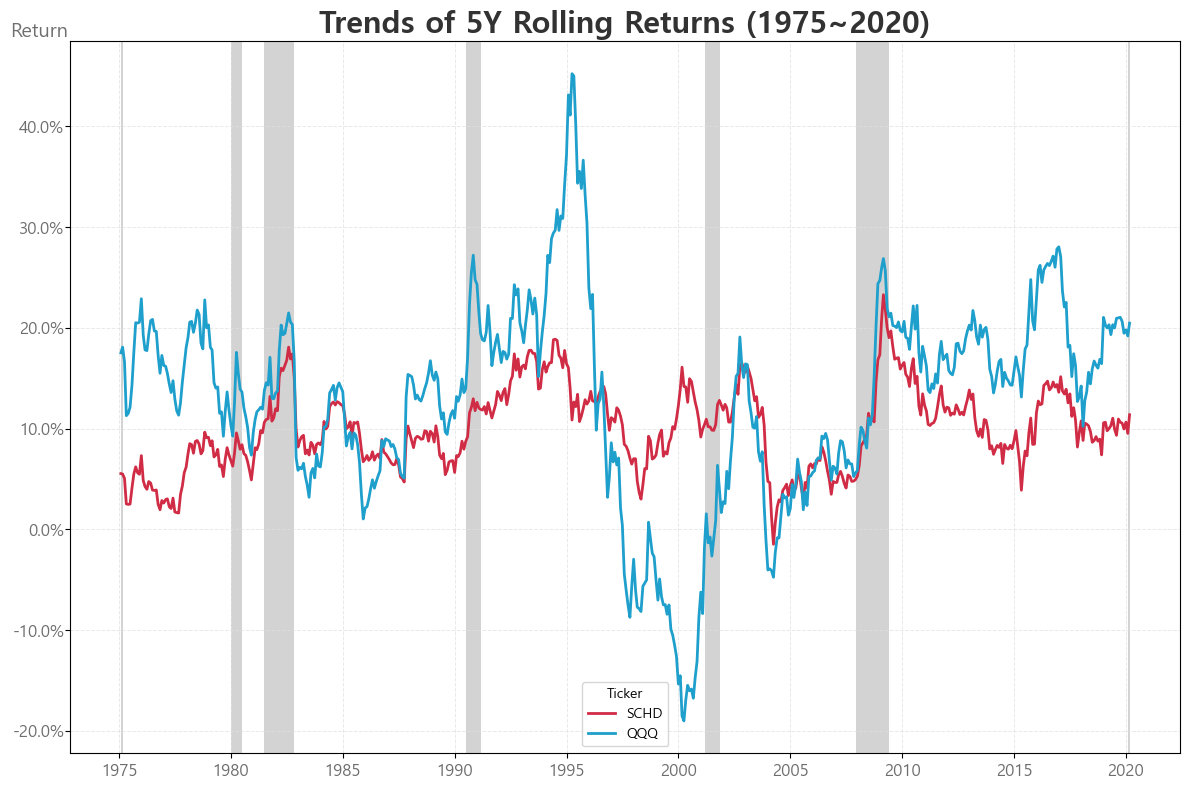

In [11]:
## 5Y Rolling Returns
rr_df = mf.get_rr_df(df_imp, assets, years=5)
gm.rr_trend_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

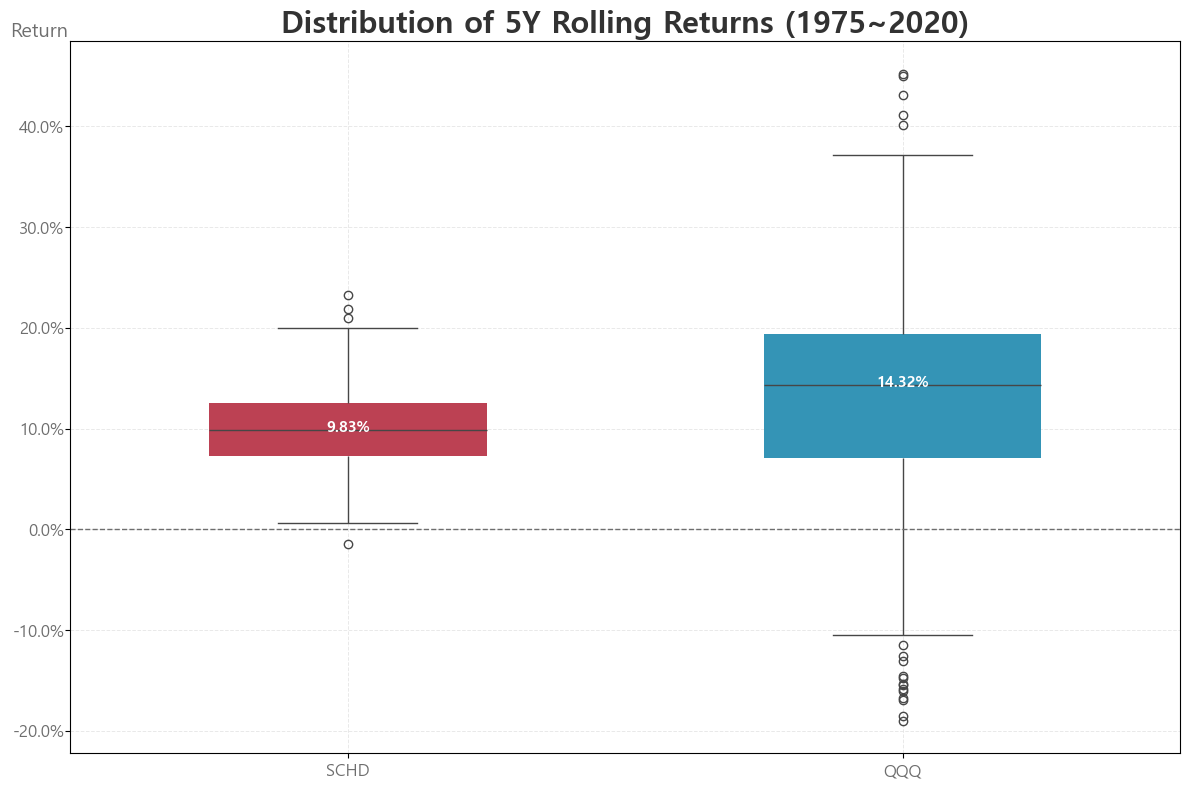

In [12]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

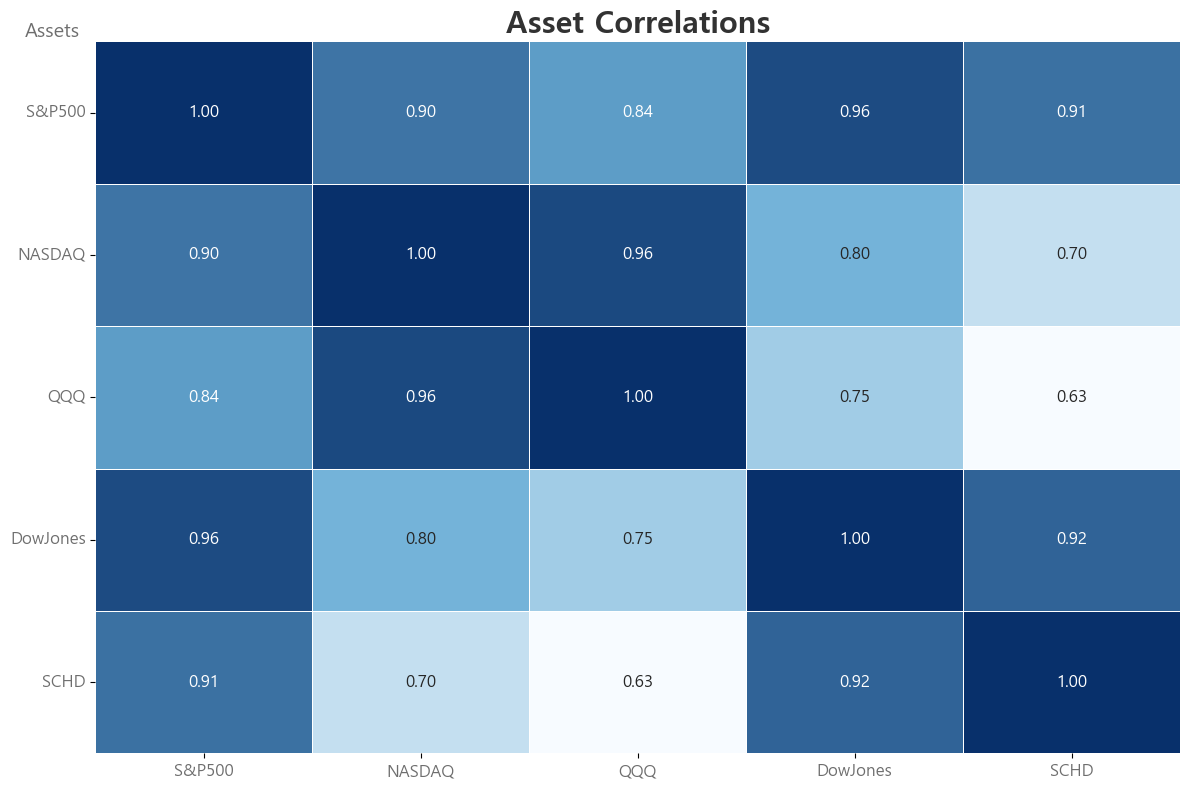

In [13]:
## 상관분석
corr_df = plot_df.pct_change()[['S&P500', 'NASDAQ', 'QQQ', 'DowJones', 'SCHD']].corr()
gm.corr_plot(corr_df)